<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/04-small_cap_value.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Small Cap Value and Momentum

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

### Alternate Code to Access SQL Server

- Hopefully, "pip3 install" has solved the Mac problems (on a Mac always use pip3 instead of pip).
- If there continues to be a problem with pymssql, it is possible to use pyodbc instead.
- On a Mac,
  - Install [Microsoft's ODBC Server](https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/install-microsoft-odbc-driver-sql-server-macos?view=sql-server-ver16)
  - Then pip3 install pyodbc
  - Then create a connection with the following code.
- If this still doesn't work, we can install and use any SQL client, for example [Azure Data Studio](https://azure.microsoft.com/en-us/products/data-studio).

In [1]:
from sqlalchemy import create_engine

server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = "mssql+pyodbc://" + username + ":" + password + "@" + server + "/" + database + "?driver=" + driver
conn = create_engine(string).connect()

### Why Long and Short?

- Can do long and short and index ETF
  - earn index return + long return - short return - short borrowing fee
  - except cannot use short proceeds to buy index or long
- to get 100 index + 100 long - 100 short, must invest 200 or borrow 100
  - earn index return + long return - short return - short borrowing fee - margin loan rate
- or buy index futures
  - implicit interest rate in futures (spot-futures parity) will be less than margin loan rate
  - but maybe bad tax consequences (40% short-term gains $\approx$ ordinary income)

### Small Cap Value and Growth

- small cap $\approx$ Russell 2000
- value usually measured by PB or PE
- some academic work (Fama-French) found PB is a better predictor of returns
- low PB = value, high PB = growth
- academics usually use BP instead of PB and call it book-to-market
- high BP = value, low BP = growth
- small-cap growth has historically had very poor returns

### Value and Momentum Portfolios I

- get marketcap data in addition to prices
- calculate momentum
- keep stocks between 1,001 and 3,000 in market cap
- create 5x5 sort on value and momentum
- compute equally weighted portfolio returns

### Value and Momentum Portfolios II

- rank each stock between 1,001 and 3,000 on value 
    - low rank = best (low pb)
- rank each stock also on momentum
    - low rank = best (high momentum)
- add ranks to get a single combined rank
    - low combined rank = best
- go long best 50 and short worst 50


### Value and Momentum Portfolios III

- For long only portfolio, choose best stocks in each sector and match sector weights to benchmark (e.g., Russell 2000).
- For long-short portfolio, match shorts and longs in each sector to get market-neutral and sector-neutral portfolio.

### Value and Momentum Portfolios IV

- Use machine learning to find the optimal way to combine value and momentum
- And add other predictors (ROE, investment rate, short-term reversal, ...)

### Data and Procedure

- Get sectors from tickers table
- Get marketcap and pb from weekly table
- Get closeadj and closeunadj from sep_weekly as before
- Calculate momentum as before
- Filter to 1,001-3,000 on marketcap each week
- Form portfolios

### Create connection

In [2]:
from sqlalchemy import create_engine
import pymssql
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 
conn = create_engine(string).connect()

### Get data

In [3]:
import pandas as pd 
tickers = pd.read_sql(
    """ 
    select ticker, sector from tickers
    """,
    conn
)
tickers.head(3)

,ticker,sector
0,A,Healthcare
1,AA,Basic Materials
2,AAAB,Financial Services


In [4]:
weekly = pd.read_sql(
    """ 
    select ticker, date, marketcap, pb, lastupdated
    from weekly
    where date>='2010-01-01' and marketcap>0 and pb>0
    order by ticker, date, lastupdated
    """,
    conn
)
weekly = weekly.groupby(["ticker", "date", "lastupdated"]).last()
weekly = weekly.droplevel("lastupdated")
weekly.head(3)

marketcap   pb
ticker date                      
A      2010-01-08    10918.4  4.4
       2010-01-15    10751.0  4.3
       2010-01-22    10744.0  4.3

In [5]:
sep_weekly = pd.read_sql(
    """ 
    select ticker, date, closeadj, closeunadj, lastupdated 
    from sep_weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date", "lastupdated"]).last()
sep_weekly = sep_weekly.droplevel("lastupdated")

### Calculate momentum

In [6]:
sep_weekly["ret"] = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
sep_weekly["annual"] = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
sep_weekly["monthly"] = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
sep_weekly["mom"] = sep_weekly.groupby("ticker", group_keys=False).apply(
    lambda d: (1+d.annual)/(1+d.monthly) - 1
)
sep_weekly = sep_weekly[["ret", "mom", "closeunadj"]].dropna().reset_index()

### Merge marketcap and pb

In [7]:
df = sep_weekly.merge(weekly, on=["ticker", "date"], how="inner")
df = df.merge(tickers, on="ticker", how="left")
df.head(3)

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector
0,A,2011-01-07,-0.000988,0.199287,41.88,14557.7,4.5,Healthcare
1,A,2011-01-14,0.008130,0.270914,42.22,14675.8,4.5,Healthcare
2,A,2011-01-21,0.050456,0.337839,44.35,15416.2,4.8,Healthcare


### Save this week's data

In [8]:
today = df[df.date==df.date.max()]
today.head(3)

,ticker,date,ret,mom,closeunadj,marketcap,pb,sector
668,A,2023-10-27,-0.059141,-0.188863,102.77,30069.2,5.4,Healthcare
981,AA,2023-10-27,-0.020825,-0.256682,23.51,4195.9,0.9,Basic Materials
1644,AADI,2023-10-27,0.039120,-0.626255,4.25,104.2,0.8,Healthcare


### Shift predictors and shift filtering variables to backtest

In [9]:
df = df.set_index(["ticker", "date"])
variables = ["mom", "pb", "marketcap", "closeunadj"]
df[variables] = df.groupby("ticker", group_keys=False)[variables].shift()
df = df.dropna()
df.head(3)

ret       mom  closeunadj  marketcap   pb      sector
ticker date                                                                  
A      2011-01-14  0.008130  0.199287       41.88    14557.7  4.5  Healthcare
       2011-01-21  0.050456  0.270914       42.22    14675.8  4.5  Healthcare
       2011-01-28 -0.075973  0.337839       44.35    15416.2  4.8  Healthcare

### Filter out penny stocks and filter to small caps

In [10]:
df = df[df.closeunadj>5]
df["rnk"] = df.groupby("date").marketcap.rank(
    ascending=False, 
    method="first"
)
df = df[(df.rnk>1000) & (df.rnk<=3000)]
df.reset_index().groupby("date").ticker.count()

date
2011-01-14    2000
2011-01-21    2000
2011-01-28    2000
2011-02-04    2000
2011-02-11    2000
              ... 
2023-09-29    1865
2023-10-06    1853
2023-10-13    1837
2023-10-20    1829
2023-10-27    1802
Name: ticker, Length: 668, dtype: int64

### Value and Momentum Portfolios I

In [11]:
df["value_group"] = df.groupby("date", group_keys=False).pb.apply(
    lambda x: pd.qcut(x, 5, labels=range(1, 6))
)
df["mom_group"] = df.groupby("date", group_keys=False).mom.apply(
    lambda x: pd.qcut(x, 5, labels=range(1, 6))
)
rets = df.groupby(["date", "value_group", "mom_group"]).ret.mean()
rets = rets.unstack().unstack()
rets.head(3)

mom_group           1                                                 2  \
value_group         1         2         3         4         5         1   
date                                                                      
2011-01-14  -0.004985 -0.014070 -0.008452 -0.006321 -0.009538 -0.006124   
2011-01-21   0.018622  0.018095  0.020878  0.013126  0.003709  0.013191   
2011-01-28  -0.026927 -0.021369 -0.030210 -0.027047 -0.030028 -0.010046   

mom_group                                            ...         4            \
value_group         2         3         4         5  ...         1         2   
date                                                 ...                       
2011-01-14  -0.011125 -0.008001 -0.010104 -0.015608  ... -0.000915 -0.011512   
2011-01-21   0.016730  0.016485  0.010804  0.009455  ...  0.010303  0.011679   
2011-01-28  -0.016295 -0.016319 -0.029533 -0.041064  ... -0.015679 -0.018504   

mom_group                                         5                      \
value_group         3         4         5         1         2         3   
date                                                                      
2011-01-14  -0.004276 -0.002012  0.002801 -0.002485 -0.012314 -0.001888   
2011-01-21   0.018304  0.011691  0.020454  0.002941  0.019437  0.018831   
2011-01-28  -0.017971 -0.019429 -0.024112 -0.015446 -0.025357 -0.016465   

mom_group                        
value_group         4         5  
date                             
2011-01-14   0.001080  0.012422  
2011-01-21   0.023021  0.009367  
2011-01-28  -0.039987 -0.043814  

[3 rows x 25 columns]

In [12]:
(52*rets.mean()).unstack().round(3)

value_group,1,2,3,4,5
mom_group,,,,,
1,0.040,0.039,0.061,0.053,-0.004
2,0.114,0.087,0.076,0.079,0.067
3,0.129,0.093,0.094,0.101,0.098
4,0.145,0.095,0.094,0.117,0.078
5,0.176,0.125,0.113,0.104,0.138


### How many stocks are in the groups?

In [13]:
counts = df.groupby(["date", "value_group", "mom_group"]).ret.count()
counts = counts.unstack().unstack()
counts.tail(3)

mom_group      1                    2                  ...   4              \
value_group    1   2   3   4   5    1   2   3   4   5  ...   1   2   3   4   
date                                                   ...                   
2023-10-13   131  74  61  57  45  103  94  57  53  60  ...  50  75  87  79   
2023-10-20   138  75  57  50  46  108  94  59  47  58  ...  58  71  80  66   
2023-10-27   144  63  54  52  48  107  94  52  57  50  ...  62  80  55  79   

mom_group         5                   
value_group   5   1   2   3   4    5  
date                                  
2023-10-13   76  32  38  76  94  128  
2023-10-20   91  28  41  85  95  117  
2023-10-27   84  36  36  74  98  117  

[3 rows x 25 columns]

### Value and Momentum Portfolios II

- Rank stocks on momentum each week: 1=best, 2=next best, etc. (best=high momentum)
- Rank stocks on pb each week: 1=best, 2=next best, etc. (best=low pb)
- Add momentum and pb ranks: lowest combined ranks are best stocks
- Test A: sort into deciles on combined ranks and compute equally weighted returns
- Test B: go long best 50 stocks and short worst 50 stocks and compute returns

In [14]:
df["mom_rnk"] = df.groupby("date", group_keys=False).mom.rank(
    ascending=False, 
    method="first"
)
df["pb_rnk"] = df.groupby("date", group_keys=False).pb.rank(
    ascending=True, 
    method="first"
)
df["combined_rnk"] = df.mom_rnk + df.pb_rnk

### Test A: Deciles

In [15]:
df["decile"] = df.groupby("date", group_keys=False).combined_rnk.apply(
    lambda x: pd.qcut(x, 10, labels=range(1, 11))
)
rets = df.groupby(["date", "decile"]).ret.mean()
rets = rets.unstack()
52*rets.mean()

decile
1     0.140992
2     0.111454
3     0.109872
4     0.106887
5     0.096466
6     0.102888
7     0.092114
8     0.057470
9     0.075204
10    0.034701
dtype: float64

### Test B: Top 50 and Bottom 50

- rank at each date on combined_rnk
- put best 50 in long portfolio at each date
- put worst 50 in short portfolio at each date
- compute equally weighted returns in each portfolio
- calculate long minus short return

In [16]:
df["rnk_long"] = df.groupby("date", group_keys=False).combined_rnk.rank(method="first")
df["rnk_short"] = df.groupby("date", group_keys=False).combined_rnk.rank(ascending=False, method="first")
longs = df[df.rnk_long<=50]
shorts = df[df.rnk_short<=50]
long_rets = longs.groupby("date").ret.mean()
short_rets = shorts.groupby("date").ret.mean()

In [17]:

print(f"annualized mean long return is {52*long_rets.mean():.2%}")
print(f"annualized mean short return is {52*short_rets.mean():.2%}")

annualized mean long return is 17.86%
annualized mean short return is 0.14%


<AxesSubplot: xlabel='date'>

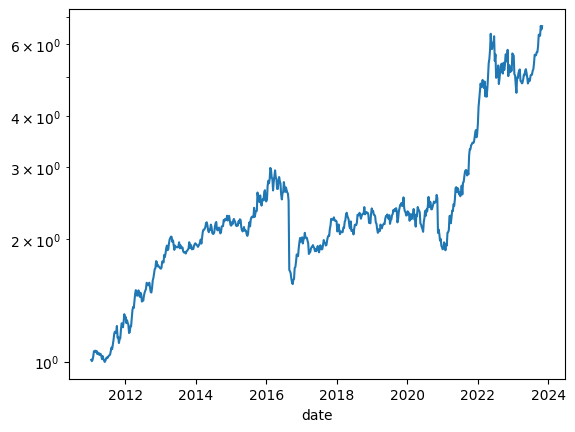

In [18]:
(1+long_rets-short_rets).cumprod().plot(logy=True)

### What are the top 50 and bottom 50 today?

- Apply penny stock and size filters to today dataframe
- Rank on momentum (low rank = high momentum = best)
- Rank on value (low rank = low pb = best)
- Add ranks
- Find best 50 and worst 50 stocks today

In [19]:
today = today.drop(columns=["date"])
today = today[today.closeunadj>5]
today["rnk"] = today.marketcap.rank(ascending=False, method="first")
today = today[(today.rnk>1000) & (today.rnk<=3000)]
today["mom_rnk"] = today.mom.rank(ascending=False, method="first").astype(int)
today["pb_rnk"] = today.pb.rank(ascending=True, method="first").astype(int)
today["combined_rnk"] = (today.mom_rnk + today.pb_rnk).astype(int)
today["rnk_long"] = today.combined_rnk.rank(method="first")
today["rnk_short"] = today.combined_rnk.rank(ascending=False, method="first")

In [20]:
long = today[today.rnk_long<=50]
long = long[["ticker", "sector", "mom_rnk", "pb_rnk", "combined_rnk", "closeunadj"]].copy()
long = long.sort_values(by="combined_rnk")

short = today[today.rnk_short<=50]
short = short[["ticker", "sector", "mom_rnk", "pb_rnk", "combined_rnk", "closeunadj"]].copy()
short = short.sort_values(by="combined_rnk")

In [21]:
long

,ticker,sector,mom_rnk,pb_rnk,combined_rnk,closeunadj
772871,EHTH,Financial Services,26,32,58,7.860
427948,CBUS,Healthcare,30,69,99,10.270
2367118,TRML,Healthcare,78,53,131,14.000
1429651,LSEA,Real Estate,97,39,136,7.240
2197648,SPHR,Communication Services,100,51,151,33.470
387833,BZH,Consumer Cyclical,48,221,269,23.430
2449388,USAP,Basic Materials,102,197,299,14.020
1761051,OPRT,Financial Services,272,44,316,5.510
1597522,MUX,Basic Materials,99,267,366,7.090
1488461,MDV,Real Estate,125,260,385,15.210


In [22]:
short

,ticker,sector,mom_rnk,pb_rnk,combined_rnk,closeunadj
2425203,UG,Consumer Defensive,1664,1382,3046,6.180
1121494,HLIT,Technology,1596,1456,3052,9.890
1570573,MRVI,Healthcare,1623,1431,3054,6.220
124978,AMLX,Healthcare,1701,1354,3055,15.740
1869626,PLMR,Financial Services,1625,1433,3058,49.360
229881,AUID,Technology,1460,1599,3059,6.000
291701,BE,Industrials,1409,1654,3063,9.780
1903132,PRCT,Healthcare,1393,1678,3071,26.090
260770,AYX,Technology,1304,1767,3071,31.460
244448,AVXL,Healthcare,1685,1399,3084,5.200


### Sector weights

In [23]:
long.groupby("sector").ticker.count()

sector
Basic Materials            3
Communication Services     2
Consumer Cyclical         11
Energy                     1
Financial Services        19
Healthcare                 4
Industrials                5
Real Estate                5
Name: ticker, dtype: int64

In [24]:
short.groupby("sector").ticker.count()

sector
Basic Materials            1
Communication Services     1
Consumer Cyclical          3
Consumer Defensive         2
Energy                     2
Financial Services         3
Healthcare                19
Industrials                3
Technology                15
Utilities                  1
Name: ticker, dtype: int64

### Value and Momentum Portfolios III

- Rank on combined rank separately in each sector
- Do that by grouping by date and sector instead of just date
- Go long best 5 and short worst 5 in each sector to get sector neutrality
- Compute equally weighted returns for long and short portfolios
- Compute long minus short return

In [25]:
df["rnk_long"] = df.groupby(["date", "sector"], group_keys=False).combined_rnk.rank(method="first")
df["rnk_short"] = df.groupby(["date", "sector"], group_keys=False).combined_rnk.rank(ascending=False, method="first")
longs = df[df.rnk_long<=5]
shorts = df[df.rnk_short<=5]
long_rets = longs.groupby("date").ret.mean()
short_rets = shorts.groupby("date").ret.mean()

In [26]:
print(f"annualized mean long return is {52*long_rets.mean():.2%}")
print(f"annualized mean short return is {52*short_rets.mean():.2%}")

annualized mean long return is 15.06%
annualized mean short return is 1.83%


<AxesSubplot: xlabel='date'>

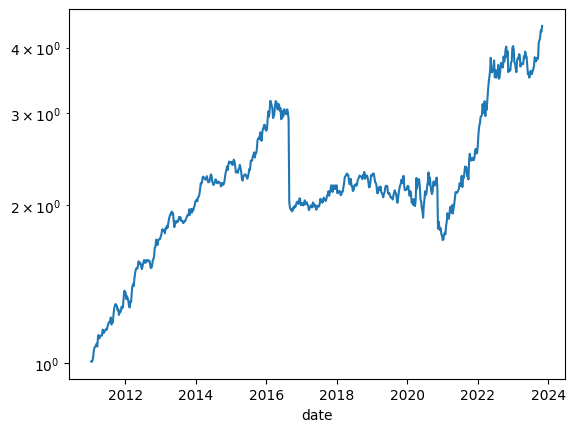

In [27]:
(1+long_rets-short_rets).cumprod().plot(logy=True)

### Best and worst stocks today in sector-neutral strategy

- Just group by sector when ranking
- Choose top 5 and bottom 5 in each sector

In [28]:
today["rnk_long"] = today.groupby("sector").combined_rnk.rank(method="first")
today["rnk_short"] = today.groupby("sector").combined_rnk.rank(ascending=False, method="first")
long_neutral = today[today.rnk_long<=5]
long_neutral = long_neutral[["ticker", "sector", "mom_rnk", "pb_rnk", "combined_rnk", "closeunadj"]].copy()
long_neutral = long_neutral.sort_values(by=["sector", "combined_rnk"])
short_neutral = today[today.rnk_short<=5].copy()
short_neutral = short_neutral[["ticker", "sector", "mom_rnk", "pb_rnk", "combined_rnk", "closeunadj"]].copy()
short_neutral = short_neutral.sort_values(by=["sector", "combined_rnk"])

In [29]:
long_neutral

,ticker,sector,mom_rnk,pb_rnk,combined_rnk,closeunadj
2449388,USAP,Basic Materials,102,197,299,14.020
1597522,MUX,Basic Materials,99,267,366,7.090
950535,FRD,Basic Materials,276,147,423,9.710
2638060,ZEUS,Basic Materials,47,636,683,49.430
986128,GATO,Basic Materials,182,579,761,5.010
2197648,SPHR,Communication Services,100,51,151,33.470
2300744,TDS,Communication Services,504,24,528,17.800
2455127,USM,Communication Services,274,430,704,41.390
1177442,IAC,Communication Services,704,159,863,41.840
2116089,SGA,Communication Services,751,195,946,19.150


In [30]:
short_neutral

,ticker,sector,mom_rnk,pb_rnk,combined_rnk,closeunadj
1433593,LTHM,Basic Materials,1633,986,2619,15.110
1573351,MSB,Basic Materials,950,1725,2675,20.170
2165284,SMID,Basic Materials,1242,1447,2689,19.366
1555752,MP,Basic Materials,1572,1207,2779,16.500
2379344,TSE,Basic Materials,1735,1708,3443,5.990
1195703,IDT,Communication Services,1159,1501,2660,27.790
1755960,OOMA,Communication Services,1203,1535,2738,10.740
934187,FNGR,Communication Services,1019,1749,2768,5.650
1042555,GOGO,Communication Services,1113,1776,2889,10.650
2388282,TTGT,Communication Services,1732,1497,3229,25.260


In [31]:
long_neutral.groupby("sector").ticker.count()

sector
Basic Materials           5
Communication Services    5
Consumer Cyclical         5
Consumer Defensive        5
Energy                    5
Financial Services        5
Healthcare                5
Industrials               5
Real Estate               5
Technology                5
Utilities                 5
Name: ticker, dtype: int64

In [32]:
short_neutral.groupby("sector").ticker.count()

sector
Basic Materials           5
Communication Services    5
Consumer Cyclical         5
Consumer Defensive        5
Energy                    5
Financial Services        5
Healthcare                5
Industrials               5
Real Estate               5
Technology                5
Utilities                 5
Name: ticker, dtype: int64

### How many shares to buy/sell?

- Can do this either for long and short or long_neutral and short_neutral
- $1,000,000 to invest long and short
- Divide by number of stocks to get $ per stock
- Divide by price to get shares per stock

### Long side

In [33]:
long_neutral["shares"] = (1000000/long_neutral.shape[0])/long_neutral.closeunadj
long_neutral["shares"] = long_neutral.shares.round(0).astype(int)
long_neutral

,ticker,sector,mom_rnk,pb_rnk,combined_rnk,closeunadj,shares
2449388,USAP,Basic Materials,102,197,299,14.020,1297
1597522,MUX,Basic Materials,99,267,366,7.090,2564
950535,FRD,Basic Materials,276,147,423,9.710,1872
2638060,ZEUS,Basic Materials,47,636,683,49.430,368
986128,GATO,Basic Materials,182,579,761,5.010,3629
2197648,SPHR,Communication Services,100,51,151,33.470,543
2300744,TDS,Communication Services,504,24,528,17.800,1021
2455127,USM,Communication Services,274,430,704,41.390,439
1177442,IAC,Communication Services,704,159,863,41.840,435
2116089,SGA,Communication Services,751,195,946,19.150,949


### Short side

In [34]:
short_neutral["shares"] = (1000000/short_neutral.shape[0])/short_neutral.closeunadj
short_neutral["shares"] = short_neutral.shares.round(0).astype(int)
short_neutral

,ticker,sector,mom_rnk,pb_rnk,combined_rnk,closeunadj,shares
1433593,LTHM,Basic Materials,1633,986,2619,15.110,1203
1573351,MSB,Basic Materials,950,1725,2675,20.170,901
2165284,SMID,Basic Materials,1242,1447,2689,19.366,939
1555752,MP,Basic Materials,1572,1207,2779,16.500,1102
2379344,TSE,Basic Materials,1735,1708,3443,5.990,3035
1195703,IDT,Communication Services,1159,1501,2660,27.790,654
1755960,OOMA,Communication Services,1203,1535,2738,10.740,1693
934187,FNGR,Communication Services,1019,1749,2768,5.650,3218
1042555,GOGO,Communication Services,1113,1776,2889,10.650,1707
2388282,TTGT,Communication Services,1732,1497,3229,25.260,720


In [35]:
with pd.ExcelWriter("portfolios 2023-11-01.xlsx") as writer:
    long.to_excel(writer, "long", index=False)
    short.to_excel(writer, "short", index=False)
    long_neutral.to_excel(writer, "long neutral", index=False)
    short_neutral.to_excel(writer, "short neutral", index=False)
    today.to_excel(writer, "today", index=False)